In [1]:
import numpy as np
import exoplanet as xo
import matplotlib.pyplot as pl
import utils
import itertools
import theano
from theano import tensor as tt

red = '#FE4365'
blue = '#00A9FF'
yellow = '#ECA25C'
green = '#3F9778'
darkblue = '#005D7F'

pl.rc('xtick', labelsize=20)
pl.rc('ytick', labelsize=20)
pl.rc('axes', labelsize=25)
pl.rc('axes', titlesize=30)
pl.rc('legend', fontsize=20)
pl.rc('lines', linewidth=4)

def fullfisher_inv(t, tparams, gpparams, a=[1]):
    a = np.array(a)
    log_s, log_w0, log_q, diag = gpparams
    Q = a[:, None]*a[None, :]
    term = xo.gp.terms.SHOTerm(log_S0=log_s, log_w0=log_w0, log_Q=log_q)
    kernel = xo.gp.terms.KroneckerTerm(term, Q)
    diag = diag * np.ones((len(a), len(t)))
    gp = xo.gp.GP(kernel=kernel, diag=diag, x=t, J=2*len(a))
    dtrans = utils.transit(t, *tparams)
    x = tt.dmatrix()
    y = tt.dmatrix()
    f = theano.function([x, y], [x.T.dot(gp.apply_inverse_vector(y))])
    fish = np.zeros((4, 4))
    for (i, j) in itertools.product([0, 1, 2, 3], [0, 1, 2, 3]):
        x = np.array(dtrans[i+1])
        y = np.array(dtrans[j+1])
        x = np.tile(x, (np.shape(Q)[0], 1)).T.reshape(1, np.shape(Q)[0]*len(x)).T
        y = np.tile(y, (np.shape(Q)[0], 1)).T.reshape(1, np.shape(Q)[0]*len(y)).T
        fish[i, j] = f(x, y)[0][0, 0]
    return fish

def fisher(t, tparams, gpparams, a=[1]):
    fish = fullfisher_inv(t, tparams, gpparams, a=a)
    return np.sqrt(np.diag(np.linalg.inv(fish)))

def fisher_white_noise_only(t, tparams, diag):
    dtrans = utils.transit(t, *tparams)
    fish = np.zeros((4, 4))
    for (i, j) in itertools.product([0, 1, 2, 3], [0, 1, 2, 3]):
        x = np.array(dtrans[i+1])
        y = np.array(dtrans[j+1])
        fish[i, j] = (1/diag)*x.T.dot(y)
    return np.sqrt(np.diag(np.linalg.inv(fish)))

In [2]:
x = np.linspace(2, 10, 10)
diag = np.exp(-15)
alpha = np.exp(-5)
alpha1 = 2 / (1 + x)
alpha2 = 2 / (1 + 1/x)
sig = np.sqrt(diag)
a = np.array([alpha1, alpha2]).T
a3 = [np.linspace(a1, a2, 3) for (a1, a2) in zip(alpha1, alpha2)]
a4 = [np.linspace(a1, a2, 4) for (a1, a2) in zip(alpha1, alpha2)]
a5 = [np.linspace(a1, a2, 5) for (a1, a2) in zip(alpha1, alpha2)]
t = np.linspace(-5, 5, 5000)
tparams = [0.0, 0.1, 1.0, 0.01]  # t0, r, d, tin
logw0 = 5.0
logq = -np.log(np.sqrt(2))

In [3]:
fish1 = [fisher_white_noise_only(t, tparams, diag) for a in a]
fish2 = [fisher(t, tparams, [np.log(alpha), logw0, logq, diag*2], a=a) for a in a]
fish3 = [fisher(t, tparams, [np.log(alpha), logw0, logq, diag*3], a=a) for a in a3]
fish4 = [fisher(t, tparams, [np.log(alpha), logw0, logq, diag*4], a=a) for a in a4]
fish5 = [fisher(t, tparams, [np.log(alpha), logw0, logq, diag*5], a=a) for a in a5]

Text(0,0.5,'1-$\\sigma$ uncertainty for $R_p/R_*$')

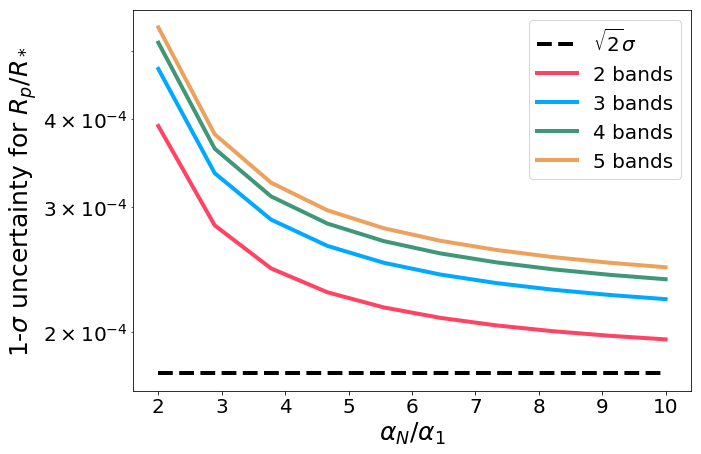

In [5]:
figure = pl.figure(figsize=(10, 7))
pl.semilogy(x, np.sqrt(2)*np.array(fish1)[:, 1], '--', color='k', label=r"$\sqrt{2}\sigma$")
pl.semilogy(x, np.array(fish2)[:, 1], '-', color=red, label="2 bands")
pl.semilogy(x, np.array(fish3)[:, 1], '-', color=blue, label="3 bands")
pl.semilogy(x, np.array(fish4)[:, 1], '-', color=green, label="4 bands")
pl.semilogy(x, np.array(fish5)[:, 1], '-', color=yellow, label="5 bands")

pl.legend()
pl.xlabel(r"$\alpha_N/\alpha_1$")
pl.ylabel(r"1-$\sigma$ uncertainty for $R_p/R_*$")